In [1]:
from pulp import *
from alb_tools import *
import itertools
from more_itertools import set_partitions
import numpy as np

# MDP model
taken from Markov decision process for multi-manned mixed-model assembly lines with walking workers Hasemi-Petroodi et. al. 2022

In [2]:
#instance_names = ['SALBP_benchmark/small data set_n=20/instance_n=20_1.alb','SALBP_benchmark/small data set_n=20/instance_n=20_2.alb' ]
instance_names = ['SALBP_benchmark/debugging_ds/instance_n=3_1.alb','SALBP_benchmark/debugging_ds/instance_n=3_2.alb' ]
test_instances = create_instance_pairs(instance_names)
NO_EQUIPMENT = 4
NO_S = 2
C_EM = 150
NO_MODELS = 2
TAKT_TIME = 250 #cadence to respect
MAX_L = 3 #maximum number of workers at a station
#STATION_MODEL_PICTURES  = {}

S_E = [(s, e ) for s in range(NO_S) for e in range(NO_EQUIPMENT)]
S_L = [(s , l) for s in range(NO_S) for l in range(1, MAX_L)]

NO_CONFIG = NO_MODELS ** NO_S #Number of possible line pictures

test_instances[0]= eliminate_tasks(test_instances[0], (0,0))
for i in range(NO_MODELS):
    test_instances[0][i]['cycle_time'] = TAKT_TIME
    test_instances[0][i]['c_em'] = C_EM
    test_instances[0][i]['max_workers'] = MAX_L

all_tasks = list_all_tasks(test_instances[0]) 

c_se, r_oe = generate_equipment(NO_EQUIPMENT,NO_S, all_tasks)
stations = list(range(NO_S))
models = list(range(NO_MODELS))
model_pairs = list(itertools.combinations(models, 2))
omega = []
enumerate_universe('', omega, NO_MODELS, NO_S)
actions = list(range(len(all_tasks) ** NO_S))
# equipment = list(range(NO_EQUIPMENT))
# workers = list(range(1, MAX_L+1))


In [3]:
print(test_instances)

[[{'num_tasks': 3, 'cycle_time': 250, 'order_strength': 0.268, 'task_times': {'1': 142, '2': 34, '3': 140}, 'precedence_relations': [('1', '2'), ('1', '3')], 'model_no': 0, 'c_em': 150, 'max_workers': 3}, {'num_tasks': 3, 'cycle_time': 250, 'order_strength': 0.3, 'task_times': {'1': 58, '2': 224, '3': 20}, 'precedence_relations': [('1', '3'), ('2', '3')], 'model_no': 1, 'c_em': 150, 'max_workers': 3}]]


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_85797/1903328287.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


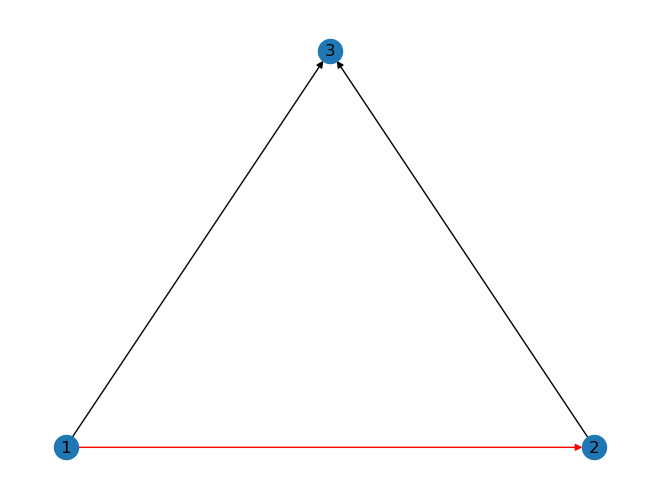

In [4]:
p_graph = nx.DiGraph()
p_graph.add_edges_from(test_instances[0][0]['precedence_relations'], color = 'r')
p_graph.add_edges_from(test_instances[0][1]['precedence_relations'], color= 'k')
colors = [p_graph[u][v]['color'] for u,v in p_graph.edges]
nx.draw_planar(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
plt.savefig("precedence_graph.png", format="PNG" )

In [5]:
test_instances[0]

[{'num_tasks': 3,
  'cycle_time': 250,
  'order_strength': 0.268,
  'task_times': {'1': 142, '2': 34, '3': 140},
  'precedence_relations': [('1', '2'), ('1', '3')],
  'model_no': 0,
  'c_em': 150,
  'max_workers': 3},
 {'num_tasks': 3,
  'cycle_time': 250,
  'order_strength': 0.3,
  'task_times': {'1': 58, '2': 224, '3': 20},
  'precedence_relations': [('1', '3'), ('2', '3')],
  'model_no': 1,
  'c_em': 150,
  'max_workers': 3}]

In [6]:
feasible_partitions = {}

for model in models:
    partitions = []
    task_partitioning(partitions, [[] for _ in range(NO_S)], list(all_tasks), NO_S,  test_instances[0][model])
    feasible_partitions[f'model_{model}'] = partitions

In [7]:
feasible_partitions

{'model_0': [[['2', '1'], ['3']], [['3', '1'], ['2']], [['1'], ['2', '3']]],
 'model_1': [[['2', '1'], ['3']], [['2'], ['3', '1']], [['1'], ['2', '3']]]}

## MDP State
### State variables
F_isd -- Equal to 1 when model i is located at station s in state d, 0 otherwise

P_osd -- equal to 1 if model 1 if task o has been already executed for the the model in station s when the sytem passed to state d, 0 otherwise


R_osa -- equal to 1 if action a performs task o on the model in station s



### Transistion variables
Tr_a_d_dprime -- probability to transistion from state d to state d' with action a


### Other parameters
q_as -- number of workers required in station s for action a






## STATE markov decision process

In [8]:
no_line_pictures = len(omega)
no_line_pictures

4

In [9]:
def create_model_histories(feasible_partitions, models, NO_S):
    model_histories = {}
    for model in models:
            feasible_histories = []
            for index, partition in enumerate(feasible_partitions[f'model_{model}']):
                feasible_history = {}
                feasible_history['index'] = index
                feasible_history['station_0'] = []
                completed_tasks = partition[0]
                for station in range(1,NO_S):
                    feasible_history[f'station_{station}'] = completed_tasks.copy()
                    completed_tasks = completed_tasks + partition[station]
                feasible_histories.append(feasible_history)
            model_histories[f'model_{model}'] = feasible_histories
    return model_histories
model_histories = create_model_histories(feasible_partitions,models, NO_S)
model_histories


{'model_0': [{'index': 0, 'station_0': [], 'station_1': ['2', '1']},
  {'index': 1, 'station_0': [], 'station_1': ['3', '1']},
  {'index': 2, 'station_0': [], 'station_1': ['1']}],
 'model_1': [{'index': 0, 'station_0': [], 'station_1': ['2', '1']},
  {'index': 1, 'station_0': [], 'station_1': ['2']},
  {'index': 2, 'station_0': [], 'station_1': ['1']}]}

In [10]:

def create_picture_hist(picture, D, d, d_count, model_histories, current_station, no_s):
    if current_station == no_s:
            d_copy = copy.deepcopy(d)
            d_copy['index'] = d_count
            D.append(d_copy)
            return d_count + 1
    for history in model_histories[f'model_{picture[current_station]}']:
        d_copy = copy.deepcopy(d)
        d_copy[f'model_at_{current_station}'] = picture[current_station]
        d_copy[f'history_at_{current_station}'] = history[f'station_{current_station}']
        d_count = create_picture_hist(picture, D, d_copy, d_count, model_histories, current_station + 1, no_s)
    return d_count
D = []
d_count = 0
for picture in omega:
    picture_hist = []
    d_count = create_picture_hist(picture, picture_hist, {},d_count,  model_histories, 0, NO_S)
    D = D + picture_hist

In [11]:
D

[{'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 0},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 1},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 2},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 3},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 4},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 5},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 6},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 7},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 8},
 {'model_at_0': '0',
  'history_at

In [12]:
len(D)

36

In [13]:
def calculate_time_and_workers(tasks, instance, model, takt_time, max_workers):
    total_time = 0
    for task in tasks:
        total_time += instance[model]['task_times'][task]
    workers = 1

    while total_time / workers > takt_time:
        workers += 1
        if workers > max_workers:
             return total_time, None, None
    reduced_time = total_time / workers
    return total_time, reduced_time, workers


def create_actions(d, A, a, a_count, instance, takt_time, max_workers,  model_histories, current_station, no_s):

    if current_station == no_s:
            a_copy = copy.deepcopy(a)
            a_copy['state_index'] = d['index']
            a_copy['action_index'] = str(d['index']) + '_' + str(a_count)
            a_copy['total_workers'] = sum(a_copy[f'workers_at_{station}'] for station in range(no_s))
            A.append(a_copy)
            return a_count + 1
    if current_station > 0 and not a[f'reduced_time_at_{current_station-1}']:
        return a_count
    
    for history in model_histories[f'model_{d[f"model_at_{current_station}"]}']:
        if d[f'history_at_{current_station}'] == history[f'station_{current_station}']:
            a_copy = copy.deepcopy(a)
            model_at_station = d[f'model_at_{current_station}']
            a_copy[f'model_at_{current_station}'] = model_at_station
            if current_station < no_s - 1:
                a_copy[f'history_at_{current_station}'] = d[f'history_at_{current_station}']
                a_copy[f'action_at_{current_station}'] =list(set(history[f'station_{current_station + 1}']) - set(d[f'history_at_{current_station}'])  )
            else:
                 a_copy[f'history_at_{current_station}'] = d[f'history_at_{current_station}']
                 a_copy[f'action_at_{current_station}'] =list(set(all_tasks) - set(d[f'history_at_{current_station}']))
            a_copy[f'total_task_time_at_{current_station}'], a_copy[f'reduced_time_at_{current_station}'], a_copy[f'workers_at_{current_station}'] = calculate_time_and_workers(a_copy[f'action_at_{current_station}'], instance, int(model_at_station), takt_time, max_workers)

            a_count = create_actions(d, A, a_copy, a_count,  instance, takt_time, max_workers,  model_histories, current_station + 1, no_s)
    return a_count
A = []
a_count = 0
for d in D:
    action = []
    a_count = create_actions(d, action, {}, a_count, test_instances[0], TAKT_TIME, MAX_L, model_histories, 0, NO_S)
    A = A + action


In [14]:
def state_transistion_probability(action, current_state, next_state, NO_S, entry_probs = (.4, .6)):
    '''Given an action, gives the probability of going from current_state to next_state '''
    for station in range(NO_S-1):
        if current_state['history_at_' + str(station)] + action['action_at_' + str(station)] != next_state['history_at_' + str(station+1)] :
            return 0
    #TODO modify the entry probabilities if we have constraints on the number of models of a given product in a line
    #returns the likelihood of going from current_state to next_state given action. This just depends on what model enters the first station
    return entry_probs[int(next_state['model_at_0'])]



In [24]:
len(A)

108

In [15]:
D

[{'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 0},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 1},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 2},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 3},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 4},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 5},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 6},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 7},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 8},
 {'model_at_0': '0',
  'history_at

In [16]:
# def calculate_transistion_probabilities_2_stations(A,D, model_histories, model_distribution= (0.4, 0.6)):
#     transistion_probabilities = np.zeros((len(D), len(D), len(A)))
#     for action_index, action in enumerate(A):
#         start_in  = action['state_index']
#         start_d = D[start_in]
#         for end_in, end_d, in enumerate(D):
#             if start_d['model_at_0'] == end_d['model_at_1']:
#                 if action['action_at_0'] == end_d['history_at_1']:
#                     print('start_in', start_in)
#                     print('end_in', end_in)

#                     print('action_index', action_index)
#                     print(action)
#                     print(start_d)
#                     print(end_d)
#                     transistion_probabilities[start_in][end_in][action_index] = model_distribution[int(start_d['model_at_0'])]
#                     print(transistion_probabilities[start_in][end_in][action_index])
#     return transistion_probabilities
# Tr_a_dd = calculate_transistion_probabilities_2_stations(A, D, model_histories)


# MDP MILP
whew, finally

### Decision Variables

W_se -- 1 if equipment e is chosen for station s, 0 otherwise

X_ad -- probability of taking action a in state d

### Other variables
y_asoi -- 1 if task o is at station s for model i during action a

In [17]:
#Parameters
WORKER_COST= 200

In [18]:

#Decision Variables
X_ad =LpVariable.dicts('X_ad', (action['action_index'] for action in A), lowBound=0, upBound=1, cat=LpContinuous )
W_se = LpVariable.dicts('W_se', (S_E), lowBound=0, upBound=1, cat=LpBinary )

In [51]:
D

[{'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 0},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 1},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 2},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 3},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 4},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 5},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 6},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['3', '1'],
  'index': 7},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1'],
  'index': 8},
 {'model_at_0': '0',
  'history_at

In [50]:
len(D)

36

In [48]:
len(A)

108

In [41]:
r_oe[1]

array([ True,  True,  True,  True])

In [32]:
W_se

{(0, 0): W_se_(0,_0),
 (0, 1): W_se_(0,_1),
 (0, 2): W_se_(0,_2),
 (0, 3): W_se_(0,_3),
 (1, 0): W_se_(1,_0),
 (1, 1): W_se_(1,_1),
 (1, 2): W_se_(1,_2),
 (1, 3): W_se_(1,_3)}

In [46]:
prob = LpProblem("MDP", LpMinimize)
prob += lpSum([X_ad[action['action_index']] * WORKER_COST * action['total_workers'] for action in A] + [W_se[s,e] * c_se[s,e] for s,e in S_E]), "Total Cost"

for d_prime in D:
    d_prime_indices = [action['action_index'] for action in A if action['state_index'] == d_prime['index']]                                                                  
    prob += lpSum([X_ad[action['action_index']] * state_transistion_probability(action, D[int(action['state_index'])], d_prime, NO_S) for action in A]) == lpSum([X_ad[action] for action in d_prime_indices]), f"State_{d_prime['index']}_probability"
prob += lpSum([X_ad[action['action_index']] for action in A]) == 1, "Sum of probabilities"
for station in range(NO_S):
    for o, task in enumerate(all_tasks):
        for model in range(NO_MODELS):
            for d in D:
                for a in A:
                    if d['index'] == a['state_index'] and d['model_at_' + str(station)] ==  a['model_at_' + str(station)] and task in a['action_at_' + str(station)]:
                        y_asoi = 1
                        prob += y_asoi * X_ad[a['action_index']] <= lpSum([r_oe[o][equipment] * W_se[station, equipment]  for equipment in range(NO_EQUIPMENT)]), f"equipment_for_o_{task}_i_{model}_s_{station}_d_{d['index']}_a_{a['action_index']}"
    #lpSum([r_oe[task, equipment] * W_se[station, equipment]  for equipment in range(NO_EQUIPMENT)])

In [47]:
prob

MDP:
MINIMIZE
236*W_se_(0,_0) + 157*W_se_(0,_1) + 260*W_se_(0,_2) + 246*W_se_(0,_3) + 160*W_se_(1,_0) + 124*W_se_(1,_1) + 189*W_se_(1,_2) + 178*W_se_(1,_3) + 400*X_ad_0_0 + 600*X_ad_0_1 + 400*X_ad_0_2 + 400*X_ad_10_30 + 600*X_ad_10_31 + 400*X_ad_10_32 + 400*X_ad_11_33 + 600*X_ad_11_34 + 400*X_ad_11_35 + 400*X_ad_12_36 + 600*X_ad_12_37 + 400*X_ad_12_38 + 400*X_ad_13_39 + 600*X_ad_13_40 + 400*X_ad_13_41 + 400*X_ad_14_42 + 600*X_ad_14_43 + 400*X_ad_14_44 + 400*X_ad_15_45 + 600*X_ad_15_46 + 400*X_ad_15_47 + 400*X_ad_16_48 + 600*X_ad_16_49 + 400*X_ad_16_50 + 400*X_ad_17_51 + 600*X_ad_17_52 + 400*X_ad_17_53 + 600*X_ad_18_54 + 400*X_ad_18_55 + 400*X_ad_18_56 + 600*X_ad_19_57 + 400*X_ad_19_58 + 400*X_ad_19_59 + 400*X_ad_1_3 + 600*X_ad_1_4 + 400*X_ad_1_5 + 600*X_ad_20_60 + 400*X_ad_20_61 + 400*X_ad_20_62 + 600*X_ad_21_63 + 400*X_ad_21_64 + 400*X_ad_21_65 + 600*X_ad_22_66 + 400*X_ad_22_67 + 400*X_ad_22_68 + 600*X_ad_23_69 + 400*X_ad_23_70 + 400*X_ad_23_71 + 600*X_ad_24_72 + 400*X_ad_24_73 + 400*

In [21]:
prob

MDP:
MINIMIZE
236*W_se_(0,_0) + 157*W_se_(0,_1) + 260*W_se_(0,_2) + 246*W_se_(0,_3) + 160*W_se_(1,_0) + 124*W_se_(1,_1) + 189*W_se_(1,_2) + 178*W_se_(1,_3) + 400*X_ad_0_0 + 600*X_ad_0_1 + 400*X_ad_0_2 + 400*X_ad_10_30 + 600*X_ad_10_31 + 400*X_ad_10_32 + 400*X_ad_11_33 + 600*X_ad_11_34 + 400*X_ad_11_35 + 400*X_ad_12_36 + 600*X_ad_12_37 + 400*X_ad_12_38 + 400*X_ad_13_39 + 600*X_ad_13_40 + 400*X_ad_13_41 + 400*X_ad_14_42 + 600*X_ad_14_43 + 400*X_ad_14_44 + 400*X_ad_15_45 + 600*X_ad_15_46 + 400*X_ad_15_47 + 400*X_ad_16_48 + 600*X_ad_16_49 + 400*X_ad_16_50 + 400*X_ad_17_51 + 600*X_ad_17_52 + 400*X_ad_17_53 + 600*X_ad_18_54 + 400*X_ad_18_55 + 400*X_ad_18_56 + 600*X_ad_19_57 + 400*X_ad_19_58 + 400*X_ad_19_59 + 400*X_ad_1_3 + 600*X_ad_1_4 + 400*X_ad_1_5 + 600*X_ad_20_60 + 400*X_ad_20_61 + 400*X_ad_20_62 + 600*X_ad_21_63 + 400*X_ad_21_64 + 400*X_ad_21_65 + 600*X_ad_22_66 + 400*X_ad_22_67 + 400*X_ad_22_68 + 600*X_ad_23_69 + 400*X_ad_23_70 + 400*X_ad_23_71 + 600*X_ad_24_72 + 400*X_ad_24_73 + 400*

In [52]:
prob.solve(solver=XPRESS_PY())

Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
FICO Xpress v9.0.3, Community, solve started 15:50:32, Jun 6, 2023
Heap usage: 625KB (peak 625KB, 256KB system)
Minimizing MILP noname using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
       685 rows          116 cols         4506 elements         8 entities
Presolved problem has:
       253 rows           44 cols         1519 elements         8 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 687KB (peak 1015KB, 256KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 4.00e-01,  1.00e+00] / [ 1.00e-01,  1.80e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 2.50e-01,  1.00e

-1

In [54]:
for v in prob.variables():

    print(v.name, v.varValue)

W_se_(0,_0) None
W_se_(0,_1) None
W_se_(0,_2) None
W_se_(0,_3) None
W_se_(1,_0) None
W_se_(1,_1) None
W_se_(1,_2) None
W_se_(1,_3) None
X_ad_0_0 None
X_ad_0_1 None
X_ad_0_2 None
X_ad_10_30 None
X_ad_10_31 None
X_ad_10_32 None
X_ad_11_33 None
X_ad_11_34 None
X_ad_11_35 None
X_ad_12_36 None
X_ad_12_37 None
X_ad_12_38 None
X_ad_13_39 None
X_ad_13_40 None
X_ad_13_41 None
X_ad_14_42 None
X_ad_14_43 None
X_ad_14_44 None
X_ad_15_45 None
X_ad_15_46 None
X_ad_15_47 None
X_ad_16_48 None
X_ad_16_49 None
X_ad_16_50 None
X_ad_17_51 None
X_ad_17_52 None
X_ad_17_53 None
X_ad_18_54 None
X_ad_18_55 None
X_ad_18_56 None
X_ad_19_57 None
X_ad_19_58 None
X_ad_19_59 None
X_ad_1_3 None
X_ad_1_4 None
X_ad_1_5 None
X_ad_20_60 None
X_ad_20_61 None
X_ad_20_62 None
X_ad_21_63 None
X_ad_21_64 None
X_ad_21_65 None
X_ad_22_66 None
X_ad_22_67 None
X_ad_22_68 None
X_ad_23_69 None
X_ad_23_70 None
X_ad_23_71 None
X_ad_24_72 None
X_ad_24_73 None
X_ad_24_74 None
X_ad_25_75 None
X_ad_25_76 None
X_ad_25_77 None
X_ad_26_78 N